In [1]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

For this simulation we need the hamiltonian and the Lindblad master equation:

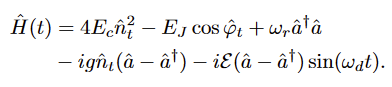

$\varepsilon$ is the drive amplitude and $\omega_d$ is the drive frequency on the resonator. $\hbar$ is assumed to be 1. $E_c$ is the transmon charging energy, $E_J$ is the Josephson energy, and n and phi are the charge and phase operators.
$E_J/E_C=50$, $E_c = 280MHz$, $\omega_t = 7.5GHz$ amd $g/2\pi=250 MHz$. The drive $\varepsilon/2\pi\epsilon [0,450] MHz$. Resonator loss rate of $\kappa/2\pi=20 MHz$. 

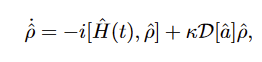

The dissipator:
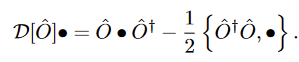
Here O and the dot are the lowering operator and density matrix respectively

The system starts in a dressed ground or excited state.

In [ ]:
E_C = 280 #MHz
E_J = 50*E_C
omega_t = 7500 #MHz
g = 2*np.pi*250 #MHz
kappa = 2*np.pi*20 #MHz
times = np.linspace(0, 1/kappa, 101)

#psi_0_ground = 
#psi_0_excited = 

#drive_amp = 